### 加载主要库

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels
import os
import geopandas as gpd
import matplotlib.cm as cm
import umap
from kneed import knee_locator
from requests import get
from urllib.parse import urlparse

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

### 定义下载函数

In [2]:
def cache_data(src:str, dest:str) -> str:

    url = urlparse(src)
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename

    if not os.path.isfile(dfn):       
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)     
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)         
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)         
        print('Done downloading...')
    else:
        print(f"Found {dfn} locally!")
    return dfn

### 下载伦敦边界等矢量

In [3]:

ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/Boroughs.gpkg locally!
Found data/Water.gpkg locally!
Found data/Greenspace.gpkg locally!
Done.


In [4]:
#检查边界投影
for g in [boros,water,green]:
    print(g.crs)

epsg:27700
epsg:27700
epsg:27700


### 下载初步清理后的inside airbnb数据集

In [5]:
#下载数据集，删除无用属性列后13MB，数据放在我的github上下载至本地
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/TiannanGe/CASA/blob/main/CASA13Foundation/' # source path
fn = 'listings.csv'
df = gpd.read_file( cache_data(spath + fn + '?raw=true', ddir) )
print('Done.')

Found data/listings.csv locally!
Done.


In [6]:
#加载数据，共69351行
df = pd.read_csv('data/listings.csv',encoding='latin-1')
df

/tmp/ipykernel_3343/2681182057.py:2: DtypeWarning: Columns (24,25,28,29,31,32,33,34,35,36,37,38,39,40,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/listings.csv',encoding='latin-1')


,id,host_location,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53
0,1.391300e+04,"London, United Kingdom",80%,70%,f,LB of Islington,3,4,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.540000e+04,"Kensington, United Kingdom",67%,29%,f,Chelsea,1,12,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.845320e+05,"London, United Kingdom",90%,67%,f,Shoreditch,1,3,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.063320e+05,"London, United Kingdom",100%,73%,t,Bethnal Green,2,5,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.740200e+04,"London, United Kingdom",90%,87%,f,Fitzrovia,6,32,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69346,9.671724e+06,"England, United Kingdom",100%,0%,f,Greenwich,15,15,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69347,2.027796e+07,"London, United Kingdom",100%,86%,t,NaN,1,1,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69348,2.051270e+07,"London, United Kingdom",83%,70%,f,NaN,1,1,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69349,4.969855e+07,"London, United Kingdom",NaN,80%,f,NaN,1,1,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 爱彼迎数据清理

In [7]:
#转换为浮点型，按需转换
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["review_scores_communication"] = pd.to_numeric(df["review_scores_communication"], errors="coerce")
df["review_scores_location"] = pd.to_numeric(df["review_scores_location"], errors="coerce")
df["review_scores_value"] = pd.to_numeric(df["review_scores_value"], errors="coerce")
df["calculated_host_listings_count"] = pd.to_numeric(df["calculated_host_listings_count"], errors="coerce")
df["availability_365"] = pd.to_numeric(df["availability_365"], errors="coerce")
df["number_of_reviews"] = pd.to_numeric(df["number_of_reviews"], errors="coerce")
df["number_of_reviews_ltm"] = pd.to_numeric(df["number_of_reviews_ltm"], errors="coerce")
df["review_scores_rating"] = pd.to_numeric(df["review_scores_rating"], errors="coerce")
df["review_scores_cleanliness"] = pd.to_numeric(df["review_scores_cleanliness"], errors="coerce")
df["beds"] = pd.to_numeric(df["beds"], errors="coerce")
df["bedrooms"] = pd.to_numeric(df["bedrooms"], errors="coerce")
df["accommodates"] = pd.to_numeric(df["accommodates"], errors="coerce")

#删除空列
df.drop(df.columns[df.columns.get_loc('calculated_host_listings_count'):], axis=1, inplace=True)

#删除经纬度的空值
df.drop(df[df.latitude.isna()].index.array, axis=0, inplace=True)
df.drop(df[df.longitude.isna()].index.array, axis=0, inplace=True)
#删除经纬度的字符型数据，保留数值型
df = df[df["latitude"].apply(lambda x: isinstance(x, (int, float)))]
df = df[df["longitude"].apply(lambda x: isinstance(x, (int, float)))]
#清理后剩余68541行
print(f"After delete Data frame is {df.shape[0]:,} x {df.shape[1]}")

After delete Data frame is 68,541 x 27


In [8]:
#对价格做清理
df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '')
df["price"] = pd.to_numeric(df["price"], errors="coerce")

/tmp/ipykernel_3343/2534484441.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '')


In [9]:
df

,id,host_location,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,beds,price,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value
0,1.391300e+04,"London, United Kingdom",80%,70%,f,LB of Islington,3,4,t,t,...,1.0,50.0,343.0,30.0,9.0,4.90,4.89,4.93,4.75,4.82
1,1.540000e+04,"Kensington, United Kingdom",67%,29%,f,Chelsea,1,12,t,t,...,1.0,75.0,70.0,89.0,0.0,4.79,4.88,4.82,4.93,4.73
2,2.845320e+05,"London, United Kingdom",90%,67%,f,Shoreditch,1,3,t,t,...,2.0,90.0,222.0,42.0,1.0,4.32,4.03,4.86,4.72,4.31
3,1.063320e+05,"London, United Kingdom",100%,73%,t,Bethnal Green,2,5,t,t,...,1.0,55.0,74.0,65.0,0.0,4.84,4.71,4.93,4.92,4.83
4,1.740200e+04,"London, United Kingdom",90%,87%,f,Fitzrovia,6,32,t,t,...,3.0,379.0,249.0,51.0,8.0,4.74,4.69,4.69,4.88,4.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69346,9.671724e+06,"England, United Kingdom",100%,0%,f,Greenwich,15,15,t,t,...,1.0,55.0,0.0,67.0,1.0,4.90,4.94,4.97,4.86,4.93
69347,2.027796e+07,"London, United Kingdom",100%,86%,t,NaN,1,1,t,t,...,3.0,201.0,0.0,61.0,12.0,4.90,4.84,4.93,5.00,4.80
69348,2.051270e+07,"London, United Kingdom",83%,70%,f,NaN,1,1,t,t,...,5.0,246.0,4.0,6.0,6.0,5.00,4.67,5.00,5.00,5.00
69349,4.969855e+07,"London, United Kingdom",NaN,80%,f,NaN,1,1,t,t,...,1.0,250.0,2.0,9.0,4.0,5.00,5.00,5.00,5.00,4.78


In [10]:
#检查数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68541 entries, 0 to 69350
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           68541 non-null  float64
 1   host_location                56263 non-null  object 
 2   host_response_rate           42131 non-null  object 
 3   host_acceptance_rate         44400 non-null  object 
 4   host_is_superhost            68515 non-null  object 
 5   host_neighbourhood           42964 non-null  object 
 6   host_listings_count          68510 non-null  object 
 7   host_total_listings_count    68533 non-null  object 
 8   host_has_profile_pic         68535 non-null  object 
 9   host_identity_verified       68536 non-null  object 
 10  neighbourhood_cleansed       68540 non-null  object 
 11  latitude                     68541 non-null  float64
 12  longitude                    68541 non-null  float64
 13  property_type   

### 清理伦敦范围外的坐标值

In [11]:
#取伦敦范围内的坐标值
df = df[(df["longitude"] >= -0.5236) & (df["longitude"] <= 0.30515)]
df = df[(df["latitude"] >= 51.27248) & (df["latitude"] <= 51.70893)]

In [12]:
#检查airbnb边界范围
print(f"The bottom-left corner is {df.longitude.min()}, {df.latitude.min()}")
print(f"The top-right corner is {df.longitude.max()}, {df.latitude.max()}")

The bottom-left corner is -0.5236, 51.27248
The top-right corner is 0.30515, 51.70893


### 定义Airbnb投影

In [13]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

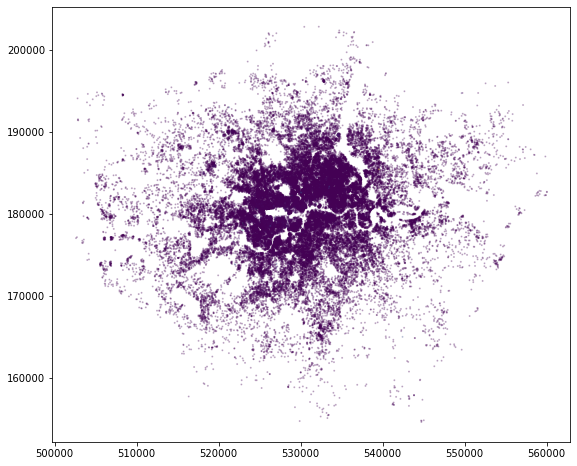

In [14]:
#投影为英国坐标并绘图，绘图耗时5秒
gdf.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

In [15]:
#定义为英国本土坐标
gdf = gdf.to_crs('epsg:27700')
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:27700
[502615.87511762 154633.50599878 560027.49389306 202832.88761803]


### 导入MSOA文件

In [16]:
#下载MSOA Excel文件
src_url   = 'https://data.london.gov.uk/download/msoa-atlas/39fdd8eb-e977-4d32-85a4-f65b92f29dcb/msoa-data.xls'
dest_path = os.path.join('data','msoa')
#使用之前已经设置的函数来读取文件
excel_atlas = pd.read_excel(
    cache_data(src_url, dest_path), 
    sheet_name='iadatasheet1',
    header=[0,1,2]) 
#检查读取文件的内容
excel_atlas.head(1)
#打印Excel的行列数
print(f"Shape of the MSOA Atlas data frame is: {excel_atlas.shape[0]:,} x {excel_atlas.shape[1]:,}")

Found data/msoa/msoa-data.xls locally!
Shape of the MSOA Atlas data frame is: 984 x 207


In [17]:
#选择部分数据作为验证数据
test = excel_atlas.drop(columns=['Mid-year Estimate totals'], axis=1, level=0)
print(f"Excel source had {excel_atlas.shape[1]} columns.")
print(f"Test now has {test.shape[1]} columns.")
#删除数据中不需要的列表
to_drop = ['Mid-year Estimate totals','Mid-year Estimates 2012, by age','Religion (2011)',
           'Land Area','Lone Parents (2011 Census)','Central Heating (2011 Census)','Health (2011 Census)',
           'Low Birth Weight Births (2007-2011)','Obesity','Incidence of Cancer','Life Expectancy',
           'Road Casualties']
tidy = excel_atlas.drop(to_drop, axis=1, level=0)
#现在列表中的数据被简化到984*111条
print(f"Shape of the MSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")


Excel source had 207 columns.
Test now has 196 columns.
Shape of the MSOA Atlas data frame is now: 984 x 111


In [18]:
#从列表中删除百分比的列表
to_drop = [x for x in tidy.columns.get_level_values(1) if (
    x.endswith("(%)") or x.startswith("%") or x.endswith("Percentages") or x.endswith("%"))]
print(to_drop)
#使用level关键字来删除这些列
tidy.drop(to_drop, axis=1, level=1, inplace=True)
#现在数据被进一步简化了
print(f"Shape of the MSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")

['Percentages', 'Percentages', 'Percentages', 'Percentages', 'Percentages', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'United Kingdom (%)', 'Not United Kingdom (%)', '% of people aged 16 and over in household have English as a main language', '% of households where no people in household have English as a main language', 'Owned: Owned outright (%)', 'Owned: Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)', 'Household spaces with at least one usual resident (%)', 'Household spaces with no usual residents (%)', 'Whole house or bungalow: Detached (%)', 'Whole house or bungalow: Semi-detached (%)', 'Whole house or bungalow: Terraced (including end-terrace) (%)', 'Flat, maisonette or apartment (%)', 'Economically active %', 'Economically inactive %', '% of households with no adults in employment: With dependent children', '% living in income depri

In [19]:
#Flattening the index
tidy.columns.values[:3]

new_cols = []
for c in tidy.columns.values:
    #打印不同的列
    l1 = f"{c[0]}"
    l2 = f"{c[1]}"
    l3 = f"{c[2]}"
    
    #新的column
    clabel = ''
    
    #从原有数列中选择新的列
    if not l1.startswith("Unnamed"):
        l1 = l1.replace(" (2011 Census)",'').replace(" (2011)",'').replace("Household ",'').replace("House Prices",'').replace("Car or van availability",'Vehicles').replace(' (2011/12)','')
        l1 = l1.replace('Age Structure','Age').replace("Ethnic Group",'').replace('Dwelling type','').replace('Income Estimates','')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'').replace(" House Price (£)",'').replace("Highest level of qualification: ",'').replace("Annual Household Income (£)",'hh Income').replace('Whole house or bungalow: ','').replace(' qualifications','')
        l2 = l2.replace('At least one person aged 16 and over in household has English as a main language',"1+ English as a main language").replace("No people in household have English as a main language","None have English as main language")
        clabel += ('-' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        clabel += ('-' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace('--','-').replace(" household",' hh').replace('Owned: ','')
    
    #clabel = clabel.replace(' (2011 Census)','').replace(' (2011)','').replace('Sales - 2011.1','Sales - 2012')
    #clabel = clabel.replace('Numbers - ','').replace(' (£)','').replace('Car or van availability','Vehicles')
    #clabel = clabel.replace('Household Income Estimates (2011/12) - ','').replace('Age Structure','Age')
    
    new_cols.append(clabel)

print(new_cols)
    

['MSOA Code', 'MSOA Name', 'Age-All Ages', 'Age-0-15', 'Age-16-29', 'Age-30-44', 'Age-45-64', 'Age-65+', 'Age-Working-age', 'Households-All Households', 'Composition-Couple hh with dependent children', 'Composition-Couple hh without dependent children', 'Composition-Lone parent hh', 'Composition-One person hh', 'Composition-Other hh Types', 'White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 'Black/African/Caribbean/Black British', 'Other ethnic group', 'BAME', 'Country of Birth-United Kingdom', 'Country of Birth-Not United Kingdom', 'Language-1+ English as a main language', 'Language-None have English as main language', 'Tenure-Owned outright', 'Tenure-Owned with a mortgage or loan', 'Tenure-Social rented', 'Tenure-Private rented', 'Household spaces with at least one usual resident', 'Household spaces with no usual residents', 'Detached', 'Semi-detached', 'Terraced (including end-terrace)', 'Flat, maisonette or apartment', 'Population Density-Persons per hectare (2012)', '

In [20]:
tidy.columns = new_cols
tidy.head()

,MSOA Code,MSOA Name,Age-All Ages,Age-0-15,Age-16-29,Age-30-44,Age-45-64,Age-65+,Age-Working-age,Households-All Households,...,Adults in Employment-No adults in employment in hh: With dependent children,Total Mean hh Income,Total Median hh Income,Vehicles-No cars or vans in hh,Vehicles-1 car or van in hh,Vehicles-2 cars or vans in hh,Vehicles-3 cars or vans in hh,Vehicles-4 or more cars or vans in hh,Vehicles-Sum of all cars or vans in the area,Vehicles-Cars per hh
0,E02000001,City of London 001,7375.0,620.0,1665.0,2045.0,2010.0,1035.0,5720.0,4385.0,...,38.0,59728.481886,46788.295472,3043.0,1100.0,173.0,51.0,18.0,1692.0,0.385861
1,E02000002,Barking and Dagenham 001,6775.0,1751.0,1277.0,1388.0,1258.0,1101.0,3923.0,2713.0,...,319.0,31788.185996,27058.703760,1020.0,1186.0,424.0,66.0,17.0,2305.0,0.849613
2,E02000003,Barking and Dagenham 002,10045.0,2247.0,1959.0,2300.0,2259.0,1280.0,6518.0,3834.0,...,268.0,43356.931547,36834.528738,1196.0,1753.0,691.0,155.0,39.0,3766.0,0.982264
3,E02000004,Barking and Dagenham 003,6182.0,1196.0,1277.0,1154.0,1543.0,1012.0,3974.0,2318.0,...,122.0,46701.436554,39668.206433,556.0,1085.0,515.0,128.0,34.0,2650.0,1.143227
4,E02000005,Barking and Dagenham 004,8562.0,2200.0,1592.0,1995.0,1829.0,946.0,5416.0,3183.0,...,307.0,34293.820288,29155.683536,1080.0,1423.0,551.0,109.0,20.0,2937.0,0.922714


In [21]:
tidy.drop(index=tidy[tidy['MSOA Code'].isna()].index, inplace=True)
#提取地区名，将不需要的部分省略
tidy['Borough'] = tidy['MSOA Name'].str.replace(' \d+$','',regex=True)
tidy.Borough.unique()

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster'], dtype=object)

In [22]:
#将borough映射到子区域
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

tidy['Subregion'] = tidy.Borough.apply(lambda x: mapping[x])


### 将数据与地理信息结合

In [23]:
#下载MSOA地理文件
msoas = gpd.read_file(
    cache_data('https://github.com/jreades/fsds/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true', 
               os.path.join('data','geo','London_MSOAs.shp.zip')), driver='ESRI Shapefile')

Found data/geo/London_MSOAs.shp.zip/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip locally!


In [24]:
tidy.columns.tolist()[:5]

['MSOA Code', 'MSOA Name', 'Age-All Ages', 'Age-0-15', 'Age-16-29']

In [25]:
msoas.columns.tolist()[:5]

['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'MSOA11NMW', 'BNG_E']

In [26]:
#将数据合并
gdf = pd.merge(msoas, tidy, left_on = 'MSOA11CD', right_on = 'MSOA Code', how='inner')
#选择部分列
gdf = gdf.drop(columns = ['MSOA11CD', 'MSOA11NM','OBJECTID'])

print(f"Final MSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final MSOA Atlas data frame has shape 983 x 86


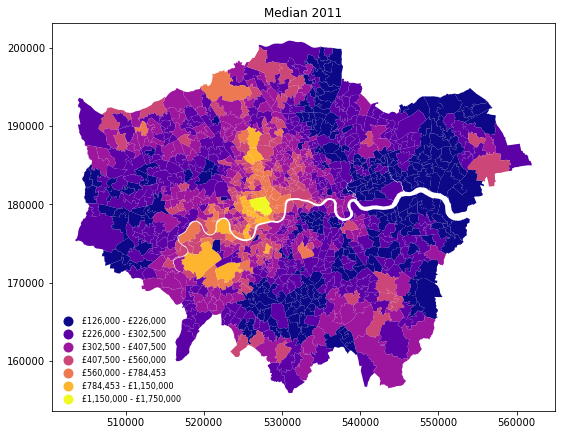

In [27]:
col = 'Median-2011'
#设置图片的输出样式
fig = gdf.plot(column=col, cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', 
         legend=True, legend_kwds={'frameon':False, 'fontsize':8},
         figsize=(9,10));
plt.title(col.replace('-',' '));

# Now to modify the legend: googling "geopandas format legend"
# brings me to: https://stackoverflow.com/a/56591102/4041902
leg = fig.get_legend()
leg._loc = 3
#设置图例
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    [low, hi] = label_text.split(', ')
    new_text = f'£{float(low):,.0f} - £{float(hi):,.0f}'
    lbl.set_text(new_text)

plt.show();
                                 

In [28]:
#保存

gdf.to_file(os.path.join('data','geo','MSOA_Atlas.gpkg'), driver='GPKG')
print("Done.")


gdf.to_feather(os.path.join('data','geo','MSOA_Atlas.geofeather'))
print("Done.")

Done.
Done.


### 将数据拆分为test and train

In [29]:
gdf = gpd.read_feather(os.path.join('data','geo','MSOA_Atlas.geofeather'))
print(gdf.shape)

(983, 86)


In [30]:
categoricals = ['Borough','Subregion']
for c in categoricals:
    gdf[c] = gdf[c].astype('category')

In [31]:
#花费训练数据与检验数据
from sklearn.model_selection import train_test_split 

pdf = gdf['Median-2011'].copy()
#使用随机方法划分两类数据集
df_train, df_test, pr_train, pr_test = train_test_split(gdf, pdf, test_size=0.2, random_state=44)


In [32]:
#检验划分后数据集的数据占比是否争取
print(f"Original data size: {gdf.shape[0]:,} x {gdf.shape[1]}")
print(f"  Training data size: {df_train.shape[0]:,} x {df_train.shape[1]} ({(df_train.shape[0]/gdf.shape[0])*100:.0f}%)")
print(f"  Testing data size:  {df_test.shape[0]:,} x {df_test.shape[1]} ({(df_test.shape[0]/gdf.shape[0])*100:.0f}%)")


Original data size: 983 x 86
  Training data size: 786 x 86 (80%)
  Testing data size:  197 x 86 (20%)


### 绘制数据

In [33]:
boros = gpd.read_file(os.path.join('data','Boroughs.gpkg'))

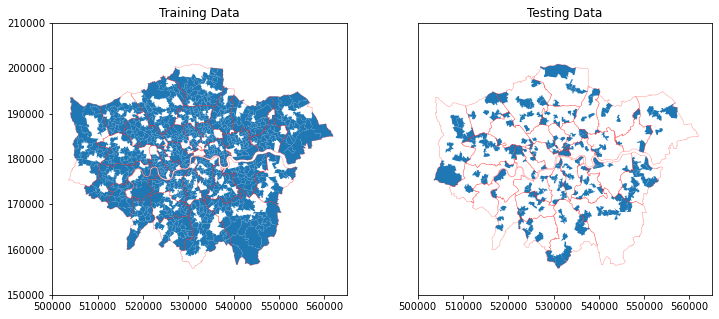

In [34]:
#绘制train and test数据的图像
f,axes = plt.subplots(1,2, figsize=(12,5))
df_train.plot(ax=axes[0])
df_test.plot(ax=axes[1])
boros.plot(ax=axes[0], facecolor='none', edgecolor='r', linewidth=.5, alpha=0.4)
boros.plot(ax=axes[1], facecolor='none', edgecolor='r', linewidth=.5, alpha=0.4)
axes[0].set_title('Training Data')
axes[1].set_title('Testing Data');
axes[0].set_ylim(150000,210000)
axes[1].set_ylim(150000,210000)
axes[0].set_xlim(500000,565000)
axes[1].set_xlim(500000,565000)
axes[1].set_yticks([]);

### 数据的归一化

In [35]:
kwds = dict(s = 7, alpha = 0.95, edgecolor = "none")
ho = ['Inner East', 'Inner West', 'Outer West and North West','Outer South','Outer East and North East']

In [36]:
cols = ['Tenure-Owned outright', 'Tenure-Owned with a mortgage or loan',
        'Tenure-Social rented', 'Tenure-Private rented']

In [37]:
# the train data
tr_raw  = df_train[cols+['Subregion']].copy()
#the test data
tst_raw = df_test[cols+['Subregion']].copy()  

In [38]:
from sklearn.preprocessing import MinMaxScaler
#使用fit函数
scalers = [MinMaxScaler().fit(df_train[x].values.reshape(-1,1)) for x in cols]

In [39]:
#use the transformations for thr train data
tr_normed = tr_raw.copy()
for i, sc in enumerate(scalers):
    # Ditto this -- can you explain what this code is doing
    tr_normed[cols[i]] = sc.transform(df_train[cols[i]].values.reshape(-1,1))

#use the transformations for thr test data
tst_normed = tst_raw.copy()
for i, sc in enumerate(scalers):
    tst_normed[cols[i]] = sc.transform(df_test[cols[i]].values.reshape(-1,1))

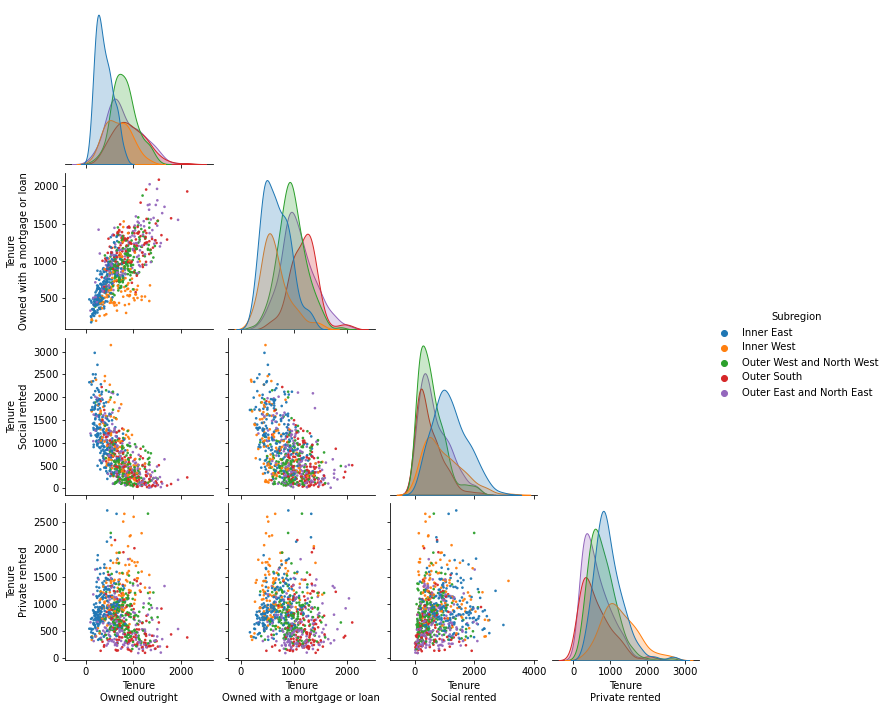

In [40]:
#绘制分布曲线
tr_raw.columns     = [re.sub('(-|/)',"\n",x) for x in tr_raw.columns.values]
tst_raw.columns    = [re.sub('(-|/)',"\n",x) for x in tst_raw.columns.values]
tr_normed.columns  = [re.sub('(-|/)',"\n",x) for x in tr_normed.columns.values]
tst_normed.columns = [re.sub('(-|/)',"\n",x) for x in tst_normed.columns.values]
sns.pairplot(data=tr_raw, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);


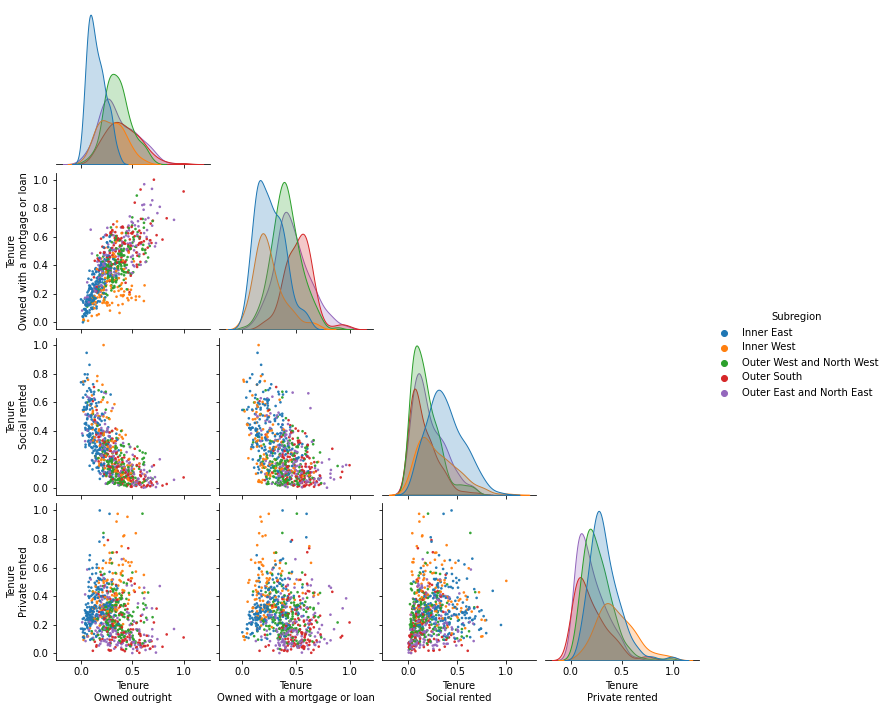

In [41]:
sns.pairplot(data=tr_normed, hue='Subregion', diag_kind='kde', corner=True, plot_kws=kwds, hue_order=ho);


### 标准化

In [42]:
#对数据进行标准化处理
col = 'Vehicles-No cars or vans in hh'
tr  = df_train[[col]].copy()
tst = df_test[[col]].copy()

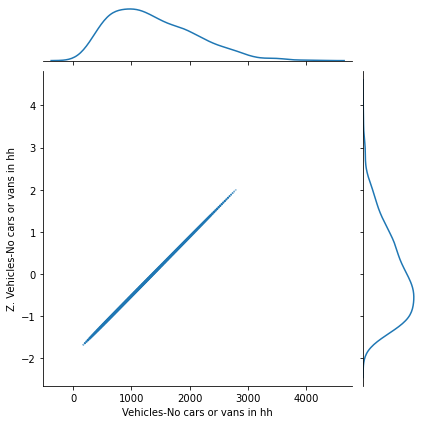

In [43]:
#Z-Score Standardisation
stsc = StandardScaler().fit(tr[col].values.reshape(-1,1))

tr[f"Z. {col}"]  = stsc.transform(tr[col].values.reshape(-1,1))
tst[f"Z. {col}"] = stsc.transform(tst[col].values.reshape(-1,1))
#分布情况
sns.jointplot(data=tr, x=f"{col}", y=f"Z. {col}", kind='kde'); # hex probably not the best choice


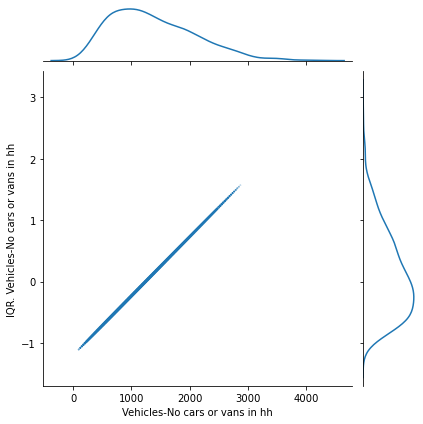

In [44]:
#四分位标准化（inter-quartile standardisation）
rs = RobustScaler(quantile_range=(25.0, 75.0)).fit(tr[col].values.reshape(-1,1))

tr[f"IQR. {col}"] = rs.transform(tr[col].values.reshape(-1,1))
tst[f"IQR. {col}"] = rs.transform(tst[col].values.reshape(-1,1))
#图像分布
sns.jointplot(data=tr, x=f"{col}", y=f"IQR. {col}", kind='kde'); # hex probably not the best choice


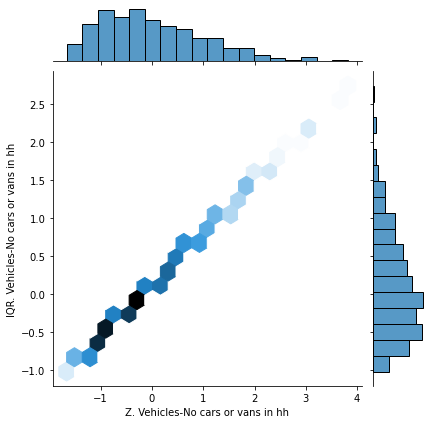

In [45]:
sns.jointplot(data=tr, x=f"Z. {col}", y=f"IQR. {col}", kind='hex'); # hex probably not the best choice


Text(0.5, 0, 'Standardised Value for No cars or vans in hh')

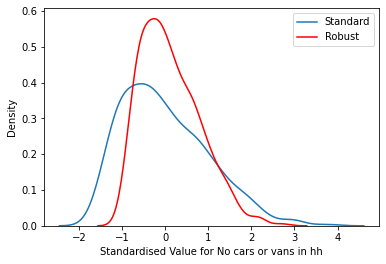

In [46]:
#比较两类缩放的不同
ax = sns.kdeplot(tr[f"Z. {col}"])
sns.kdeplot(tr[f"IQR. {col}"], color='r', ax=ax)
plt.legend(loc='upper right', labels=['Standard', 'Robust']) # title='Foo'
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Standardised Value for No cars or vans in hh")

In [47]:
#进行正态分布转换
#正态分布转化函数
def normal_from_dist(series):  #define function name and required arguments (in this case a pandas series)
    mu = series.mean()         #calculate the mean of our data
    sd = series.std()          #calculate the standard deviation of our data
    n  = len(series)           #count how many observations are in our data
    s = np.random.normal(mu, sd, n)   #use the parameters of the data just calculated to generate n random numbers, drawn from a normal distributions 
    return s                   #return this set of random numbers

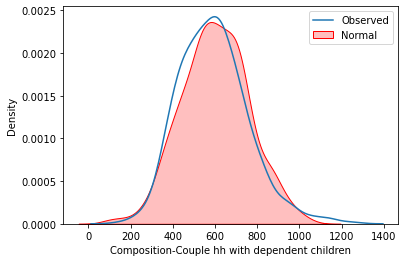

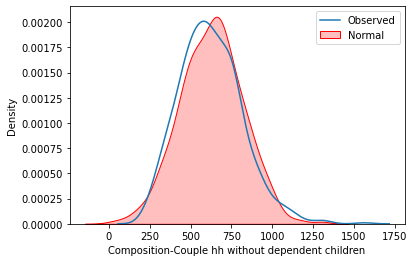

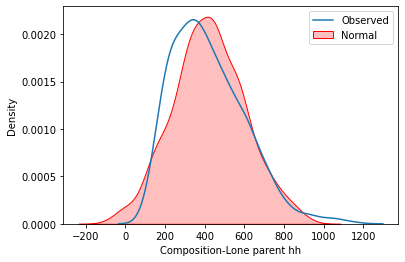

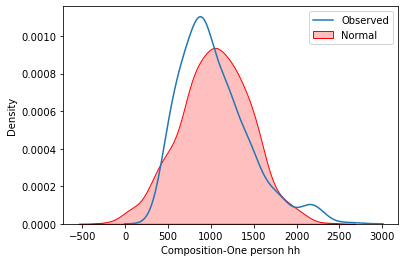

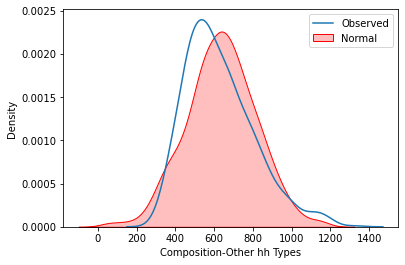

In [48]:
#通过图像来直观比较是否需要将数据进行正态转化
selection = [x for x in df_train.columns.values if x.startswith('Composition')]

for c in selection:
    ax = sns.kdeplot(df_train[c])
    sns.kdeplot(normal_from_dist(df_train[c]), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title='Foo'
    ax.ticklabel_format(useOffset=False, style='plain')
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.show()

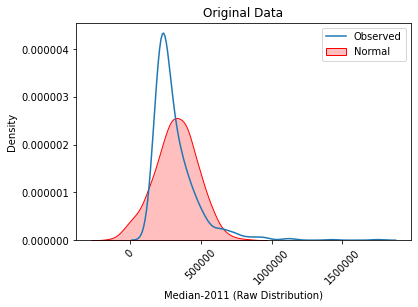

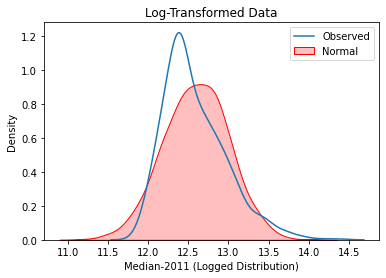

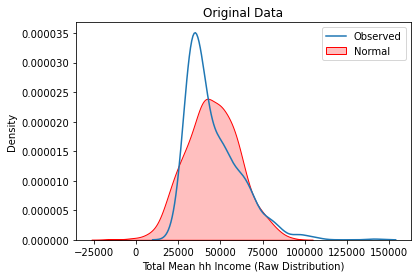

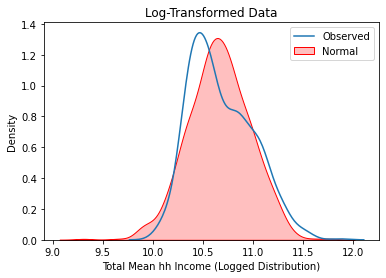

In [49]:
#Logarithmic Transformations
cols = ['Median-2011','Total Mean hh Income']

for m in cols:
    s  = df_train[m] # s == series
    ts = np.log(s)   # ts == transformed series
    
    ax = sns.kdeplot(s)
    sns.kdeplot(normal_from_dist(s), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal']) # title also an option
    plt.title("Original Data")
    
    ### USEFUL FORMATTING TRICKS ###
    # This turns off scientific notation in the ticklabels
    ax.ticklabel_format(useOffset=False, style='plain')
    # Notice this snippet of code
    ax.set_xlabel(ax.get_xlabel() + " (Raw Distribution)")
    # Notice this little code snippet too
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    
    plt.show()
    
    ax = sns.kdeplot(ts)
    sns.kdeplot(normal_from_dist(ts), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal'])
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel(ax.get_xlabel() + " (Logged Distribution)")
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.title("Log-Transformed Data")
    plt.show()

Using lambda (transform 'exponent') of -0.87702


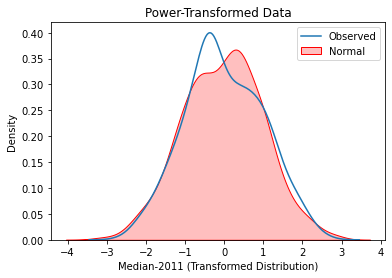

Using lambda (transform 'exponent') of -0.72212


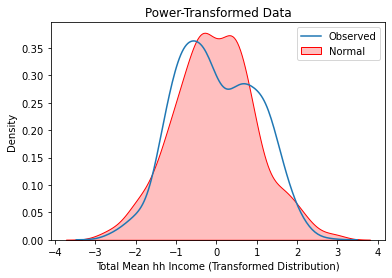

In [50]:
#Power Transformations
cols = ['Median-2011','Total Mean hh Income']
pt = PowerTransformer(method='yeo-johnson')

for m in cols:
    s  = df_train[m] # s == series
    ts = pt.fit_transform(s.values.reshape(-1,1))
    print(f"Using lambda (transform 'exponent') of {pt.lambdas_[0]:0.5f}")
    
    ax = sns.kdeplot(ts.reshape(-1,))
    
    sns.kdeplot(normal_from_dist(ts), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal'])
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel(m + " (Transformed Distribution)")
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.title("Power-Transformed Data")
    plt.show();

### 主成分分析

In [51]:
#计算份额
gdf[['Age-All Ages','Households-All Households']].head(5)

,Age-All Ages,Households-All Households
0,7375.0,4385.0
1,6775.0,2713.0
2,10045.0,3834.0
3,6182.0,2318.0
4,8562.0,3183.0


In [52]:
#指定全部列
total_pop = gdf['Age-All Ages']
total_hh  = gdf['Households-All Households']
total_vec = gdf['Vehicles-Sum of all cars or vans in the area']

In [53]:
#制定Pop or HH分布的列
pop_cols  = ['Age-', 'Composition-', 'Qualifications-', 'Economic Activity-', 'White', 'Mixed/multiple',
             'Asian/Asian British', 'Black/African', 'BAME', 'Other ethnic',
             'Country of Birth-']
hh_cols   = ['Language-', 'Tenure-', 'Households-', 'Detached', 'Semi-detached', 'Terraced', 'Flat, ']

In [54]:
popre = re.compile(r'^(?:' + "|".join(pop_cols) + r')')
hhre  = re.compile(r'^(?:' + "|".join(hh_cols) + r')')

In [55]:
#对这些列进行处理
tr_gdf = gdf.copy()
tr_gdf['Mean hh size'] = tr_gdf['Age-All Ages']/tr_gdf['Households-All Households']

for c in gdf.columns:
    print(c)
    if popre.match(c):
        print("  Normalising by total population.")
        tr_gdf[c] = gdf[c]/total_pop
    elif hhre.match(c):
        print("  Normalising by total households.")
        tr_gdf[c] = gdf[c]/total_hh
    elif c.startswith('Vehicles-') and not c.startswith('Vehicles-Cars per hh'):
        print("  Normalising by total vehicles.")
        tr_gdf[c] = gdf[c]/total_vec
    else:
        print("  Passing through.")

MSOA11NMW
  Passing through.
BNG_E
  Passing through.
BNG_N
  Passing through.
LONG
  Passing through.
LAT
  Passing through.
Shape__Are
  Passing through.
Shape__Len
  Passing through.
geometry
  Passing through.
MSOA Code
  Passing through.
MSOA Name
  Passing through.
Age-All Ages
  Normalising by total population.
Age-0-15
  Normalising by total population.
Age-16-29
  Normalising by total population.
Age-30-44
  Normalising by total population.
Age-45-64
  Normalising by total population.
Age-65+
  Normalising by total population.
Age-Working-age
  Normalising by total population.
Households-All Households
  Normalising by total households.
Composition-Couple hh with dependent children
  Normalising by total population.
Composition-Couple hh without dependent children
  Normalising by total population.
Composition-Lone parent hh
  Normalising by total population.
Composition-One person hh
  Normalising by total population.
Composition-Other hh Types
  Normalising by total populati

In [56]:
#需要移除无用的列
pcadf = tr_gdf.drop(columns=['Age-All Ages', 'Households-All Households',
                             'Vehicles-Sum of all cars or vans in the area'])
#移除非数据的列
pcadf.select_dtypes(['category','object']).columns

pcadf.drop(columns=pcadf.select_dtypes(['category','object']).columns.to_list(), inplace=True)
pcadf.drop(columns=['BNG_E','BNG_N','geometry', 'LONG', 'LAT','Shape__Are', 'Shape__Len'], inplace=True)
pcadf.columns

Index(['Age-0-15', 'Age-16-29', 'Age-30-44', 'Age-45-64', 'Age-65+',
       'Age-Working-age', 'Composition-Couple hh with dependent children',
       'Composition-Couple hh without dependent children',
       'Composition-Lone parent hh', 'Composition-One person hh',
       'Composition-Other hh Types', 'White', 'Mixed/multiple ethnic groups',
       'Asian/Asian British', 'Black/African/Caribbean/Black British',
       'Other ethnic group', 'BAME', 'Country of Birth-United Kingdom',
       'Country of Birth-Not United Kingdom',
       'Language-1+ English as a main language',
       'Language-None have English as main language', 'Tenure-Owned outright',
       'Tenure-Owned with a mortgage or loan', 'Tenure-Social rented',
       'Tenure-Private rented',
       'Household spaces with at least one usual resident',
       'Household spaces with no usual residents', 'Detached', 'Semi-detached',
       'Terraced (including end-terrace)', 'Flat, maisonette or apartment',
       'Populatio

In [57]:
# rescale and reduce the data
# Set up the Robust Rescaler for inter-decile standardisation
rs = RobustScaler(quantile_range=(10.0, 90.0))

for c in pcadf.columns.values:
    pcadf[c] = rs.fit_transform(pcadf[c].values.reshape(-1, 1))

In [58]:
#PCA Reduce

from sklearn.decomposition import PCA 

pca = PCA(n_components=50, whiten=True) 

pca.fit(pcadf)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

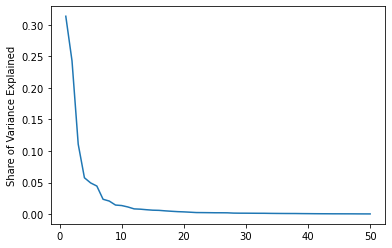

In [59]:
#检验解释变量

x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

In [60]:
for i in range(0, 20):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")


Component  0 accounts for 31.35% of variance
Component  1 accounts for 24.29% of variance
Component  2 accounts for 11.09% of variance
Component  3 accounts for 5.77% of variance
Component  4 accounts for 4.95% of variance
Component  5 accounts for 4.46% of variance
Component  6 accounts for 2.36% of variance
Component  7 accounts for 2.08% of variance
Component  8 accounts for 1.45% of variance
Component  9 accounts for 1.37% of variance
Component 10 accounts for 1.14% of variance
Component 11 accounts for 0.84% of variance
Component 12 accounts for 0.80% of variance
Component 13 accounts for 0.71% of variance
Component 14 accounts for 0.64% of variance
Component 15 accounts for 0.61% of variance
Component 16 accounts for 0.53% of variance
Component 17 accounts for 0.47% of variance
Component 18 accounts for 0.41% of variance
Component 19 accounts for 0.37% of variance


Knee detected at: 7


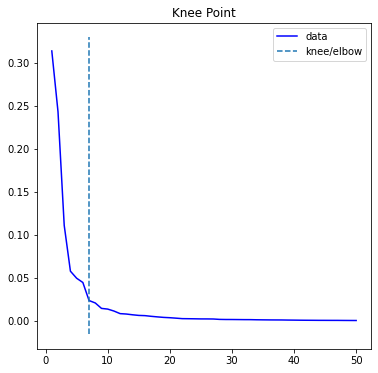

In [61]:
#寻找影响因素中的关键变量
kn = knee_locator.KneeLocator(x, explained_variance, 
                              curve='convex', direction='decreasing', 
                              interp_method='interp1d')
print(f"Knee detected at: {kn.knee}")
kn.plot_knee()


In [72]:
keep_n_components = 7

# If we weren't changing the number of components we
# could re-use the pca object created above. 
pca = PCA(n_components=keep_n_components, whiten=True)

X_train = pca.fit_transform(pcadf)

# Notice that we get the _same_ values out,
# so this is a *deterministic* process that
# is fully replicable (allowing for algorithmic
# and programming language differences).
print(f"Total explained variance: {pca.explained_variance_ratio_.sum()*100:2.2f}%")
for i in range(0, keep_n_components):
    print(f"  Component {i:>2} accounts for {pca.explained_variance_ratio_[i]*100:>5.2f}% of variance")

# Notice...
print(f"X-train shape: {len(X_train)}")
print(f"PCA df shape: {pcadf.shape[0]}")
# So each observation has a row in X_train and there is 
# 1 column for each component. This defines the mapping
# of the original data space into the reduced one
print(f"Row 0 of X-train contains {len(X_train[0])} elements.") 


Total explained variance: 89.62%
  Component  0 accounts for 25.55% of variance
  Component  1 accounts for 20.89% of variance
  Component  2 accounts for 12.18% of variance
  Component  3 accounts for  8.66% of variance
  Component  4 accounts for  8.13% of variance
  Component  5 accounts for  7.80% of variance
  Component  6 accounts for  6.42% of variance
X-train shape: 983
PCA df shape: 983
Row 0 of X-train contains 7 elements.


,Age-0-15,Age-16-29,Age-30-44,Age-45-64,Age-65+,Age-Working-age,Composition-Couple hh with dependent children,Composition-Couple hh without dependent children,Composition-Lone parent hh,Composition-One person hh,...,Vehicles-4 or more cars or vans in hh,Vehicles-Cars per hh,Mean hh size,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7
900,-0.413581,0.181540,0.245790,0.019537,0.153704,0.326558,0.025258,0.543051,-0.423986,0.220363,...,0.158616,0.093714,-0.285982,1.283399,0.359126,-0.761009,0.582816,-0.430177,-0.804040,-0.745848
174,-0.316220,0.799595,0.019620,-0.311113,-0.212422,0.522622,-0.553905,-0.081935,-0.024122,0.316213,...,-0.393933,-0.432991,-0.104366,0.470924,-1.060878,0.310805,-0.509589,2.304544,-1.326368,0.873320
290,-0.052117,-0.400588,-0.251203,0.597823,0.539147,-0.230145,0.515756,0.413576,-0.358760,-0.235743,...,0.725746,0.626903,0.111922,0.785892,1.424752,0.961449,-0.358583,-0.546838,-0.626315,-0.133681
656,0.130991,-0.120297,0.182551,0.115323,-0.018937,0.042515,-0.160654,-0.108553,0.597021,0.333595,...,0.069727,-0.143665,-0.261366,-0.401122,-0.161284,-0.790061,-0.812274,-0.334325,-0.049990,-0.155825
314,0.274612,-0.014891,-0.083410,-0.090453,0.187111,-0.217629,-0.174822,-0.279840,0.370035,-0.005116,...,-0.180438,-0.170935,0.126769,-0.870827,-0.181948,0.347651,-1.174373,0.084892,-0.267402,-0.017764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.535437,0.449647,-0.154157,-0.411884,-0.315197,-0.044712,-0.051228,-0.852335,0.030687,-0.384163,...,-0.155213,-0.330316,0.916240,-1.331251,-1.188454,1.511646,0.899642,-0.261359,-0.235671,-0.023873
860,-0.026539,0.347386,0.485993,-0.405048,-0.304043,0.371371,-0.078426,0.042717,0.077038,0.255982,...,-0.115972,-0.250715,-0.210910,-0.091626,-0.713405,-0.143911,-0.104793,-0.237796,-0.696188,-0.103748
317,-0.279899,-0.272314,0.358677,0.109580,0.424292,0.026397,0.165718,0.391849,-0.292245,0.606874,...,0.073767,-0.052192,-0.427603,0.623846,0.261816,-0.553873,-0.875630,-0.345143,-0.679887,-0.630539
192,0.547071,-0.185686,-0.069737,0.223311,-0.189771,-0.145845,-0.143285,-0.471799,0.863351,0.238117,...,-0.180538,-0.100882,-0.103148,-0.902178,-0.258296,-0.675662,-0.499705,-0.436032,0.822159,0.532341


In [63]:
#列表间的组合
for i in range(0,keep_n_components):
    s = pd.Series(X_train[:,i], index=pcadf.index)
    pcadf[f"Component {i+1}"] = s


In [71]:
pcadf.sample(100)

,Age-0-15,Age-16-29,Age-30-44,Age-45-64,Age-65+,Age-Working-age,Composition-Couple hh with dependent children,Composition-Couple hh without dependent children,Composition-Lone parent hh,Composition-One person hh,...,Vehicles-4 or more cars or vans in hh,Vehicles-Cars per hh,Mean hh size,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7
434,-0.119634,0.282833,0.469761,-0.355496,-0.152444,0.330038,0.077723,0.007679,-0.229361,-0.244586,...,0.053601,0.028418,0.246621,-0.287570,-0.348041,-0.133970,1.816990,-0.275733,-0.628083,-0.199460
771,0.042495,-0.459621,0.267516,0.505698,0.050098,0.058501,0.811208,0.535906,-0.346027,0.198862,...,0.104800,0.359329,-0.253486,0.933448,1.077159,-0.534197,-0.317906,-0.489084,-1.097876,1.357911
40,-0.254293,-0.072742,0.241505,0.000000,0.363036,0.052167,0.104530,0.121395,-0.217218,0.173641,...,-0.103540,0.052421,-0.116753,0.231057,-0.116167,-0.593604,1.199713,-0.438959,0.229520,-0.550615
769,-0.146682,0.115383,-0.266402,0.479577,0.065256,0.190170,0.473045,0.332091,-0.411454,-0.032653,...,0.271252,0.473869,0.184177,0.882027,1.025989,0.625317,-0.183921,2.201020,-2.012973,2.408120
259,0.377724,0.104068,-0.093530,-0.015612,-0.146019,-0.050201,-0.214646,-0.626538,0.258626,-0.439386,...,0.736791,0.087153,1.001716,-1.189548,-0.506446,1.172739,0.650044,-0.143474,1.384594,-0.360680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,-1.301165,0.704603,0.302355,0.150108,0.153997,0.996473,-1.040996,0.286634,-0.505975,1.550762,...,1.031207,-0.429207,-0.706884,3.536283,-1.350111,1.651545,-0.226172,3.032293,4.701637,0.119665
278,-0.554234,-0.266992,-0.128947,0.442486,0.894389,-0.112603,-0.000246,0.554845,-0.238725,0.629169,...,0.248415,0.342352,-0.476378,0.474326,1.067099,-1.525740,0.404001,0.846664,0.718479,-1.294289
712,0.641201,0.114777,-0.025712,-0.283221,-0.234880,-0.183700,0.072899,-0.612163,0.085721,-0.375059,...,-0.219000,-0.148484,0.699191,-0.984444,-0.546047,0.492597,1.098026,-0.742069,0.405440,0.694164
677,0.310354,-0.038209,-0.009035,0.066370,-0.056930,-0.064931,0.056943,-0.253049,0.438965,-0.055267,...,0.027331,0.054323,0.091297,-0.769422,0.020679,-0.368617,-0.042447,-0.117251,0.521448,0.960079


In [65]:
#与地理数据相结合
msoas = gpd.read_file(
    cache_data('https://github.com/jreades/fsds/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true', 
               os.path.join('data','geo','London_MSOAs.shp.zip')), driver='ESRI Shapefile')
print(msoas.columns)


Found data/geo/London_MSOAs.shp.zip/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip locally!
Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'MSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


In [66]:
gpcadf = pd.merge(msoas.set_index(['MSOA11CD'], drop=True), pcadf, left_index=True, right_index=True, how='inner')
print(f"Geo-PCA df has shape {gpcadf.shape[0]} x {gpcadf.shape[1]}")

Geo-PCA df has shape 0 x 89


In [67]:
gpcadf['Borough'] = gpcadf.MSOA11NM.apply(lambda x: x[:-4])

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


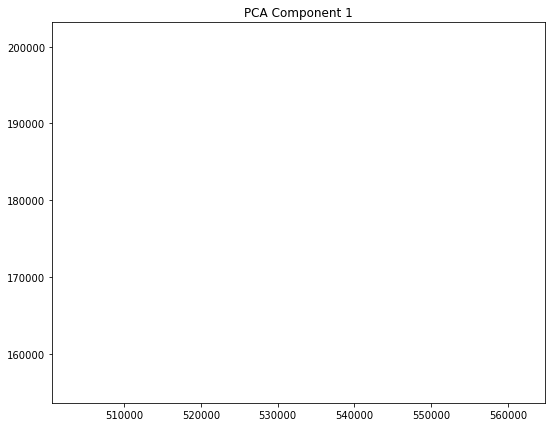

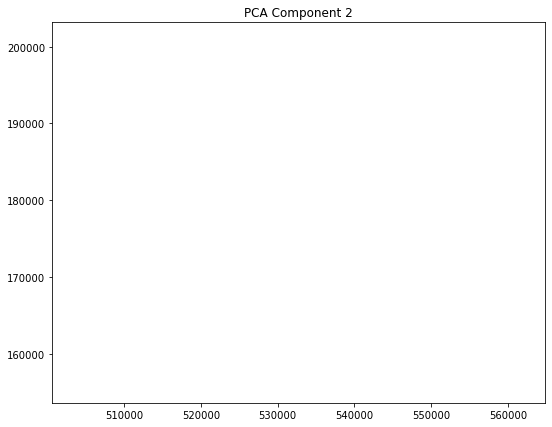

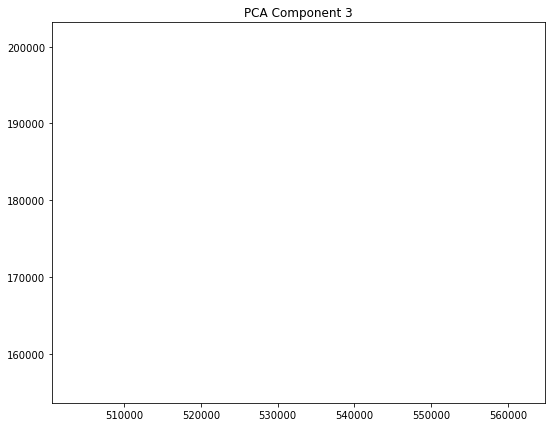

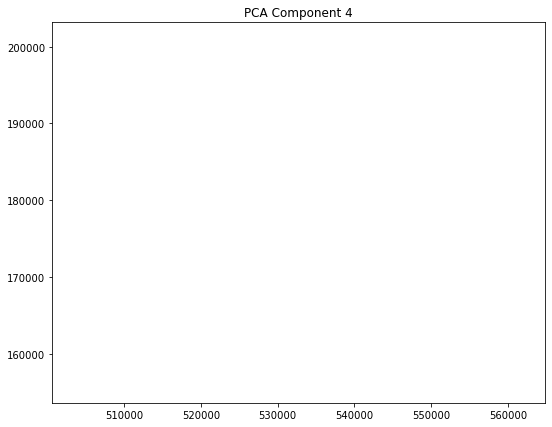

In [68]:
for comp in [f"Component {x}" for x in range(1,5)]:
    ax = gpcadf.plot(column=comp, cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
    boros.plot(ax=ax, edgecolor='w', facecolor='none', linewidth=1, alpha=0.7)
    ax.set_title(f'PCA {comp}')

### 将清理过的csv文件保存为feather格式文件至本地

In [69]:
print(f"Using 'listings.feather' as basis for saving data...")
gdf.to_feather(os.path.join('data',fn.replace('.csv','.feather')))

Using 'listings.feather' as basis for saving data...


### 初步分析、直方图、箱型图

In [70]:
#价格区间，平均数，中位数
print(f"The range of price is ${gdf.price.min():,.2f} to ${gdf.price.max():,.2f}")
print(f"The mean and median of the price are ${gdf.price.mean():,.2f} and ${gdf.price.median():,.2f}")

AttributeError: 'GeoDataFrame' object has no attribute 'price'

In [ ]:
#价格直方图
ax = gdf.price.plot.hist(bins=200, figsize=(13,3)); # Oooooh, let's use a *pandas* method here
ax.set_xlim(0,2500)

In [ ]:
#价格箱型图
ax = gdf.price.plot.box(vert=False, figsize=(13,3))
ax.set_xlim(0,2500)

In [ ]:
#价格箱型图1
gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);

In [ ]:
#价格箱型图2
print(f"gdf has {gdf.shape[0]:,.0f} rows.")
gdf.drop(gdf[gdf.price==0].index, axis=0, inplace=True)
gdf.drop(gdf[gdf.price < 5].index, axis=0, inplace=True)
gdf.drop(gdf[gdf.price > 1000].index, axis=0, inplace=True)
gdf['lnprice'] = np.log(gdf.price)#价格对数
print(f"gdf now has {gdf.shape[0]:,.0f} rows.")
print(f"The range of price is {gdf.price.min():,.2f} to {gdf.price.max():,.2f}")
print(f"The range of ln(price) is {gdf.lnprice.min():,.4f} to {gdf.lnprice.max():,.4f}")
gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Price (Outliers not shown)")
plt.show()
gdf.lnprice.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Ln(Price) (Outliers not shown)")
plt.show()

### Airbnb房源每晚价格的自然对数图

In [ ]:
#Airbnb房源每晚价格的自然对数图，出图等待五秒
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Plot of Natural Log of Nightly Price for Airbnb Listings (Outliers Removed)");

### Airbnb房源每晚价格的自然对数图（伦敦中心）

In [ ]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Ln(Price/Night) for Airbnb Listings (Central London Detail)")
ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000]);

In [ ]:
#出图等待
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True); # Note that the legend *label* had to go -- there are other ways to add it

ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000])

### 叠加出图（局部）

In [ ]:
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

fontname = "Liberation Sans Narrow"

tgdf = gdf[(gdf.geometry.x > 525000) & (gdf.geometry.x < 540000) & (gdf.geometry.y > 176000) & (gdf.geometry.y < 186000)].copy()

q = mc.Quantiles(tgdf.price.values, k=5)

tgdf['bins'] = q.yb

f,ax = plt.subplots(figsize=(15,9))
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14, 0.25), zorder=1, ax=ax)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', zorder=2, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, zorder=3, ax=ax)

ax.set_xlim([525000,540000])
ax.set_ylim([176000,186000])

ax.axis('off') # Don't plot the axes

tgdf.plot(column='bins', categorical=True,
         cmap='viridis', legend=True, marker='.', markersize=1.5, zorder=4, ax=ax)

ax.set_title('London Airbnb Listings Price Per Night', 
             fontdict={'fontsize':'20', 'fontweight':'3', 'family':fontname})  #provide a title

for c in ax.collections:
    # Find the layer with the data
    if c.get_zorder()==4:

        handles, _ = c.legend_elements(prop="colors")
        legend1 = ax.legend(handles, q.get_legend_classes(fmt='{:.2f}'), 
                            loc="upper right", title="Price per Night", 
                            prop={'size':'10', 'weight':'1', 'family':fontname})
        ax.add_artist(legend1)

# And don't forget to add a source!
a = ax.text(tgdf.geometry.x.max(), tgdf.geometry.y.min(), 'Source: InsideAirbnb (2022)', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=14, fontweight=4, color='#333333', family=fontname)

# And this is a nice feature: show the distribution!
ax2 = legendgram(f, ax, 
           tgdf.price, q.bins, bins=round(gdf.price.max()/25),
           pal=palmpl.Viridis_5,
           legend_size=(0.3, 0.1), 
           loc='lower left',
           clip=(0,1000),
           frameon=True
    )

for tk in ax2.get_xticklabels():
    tk.set_fontname(fontname)
    